# MNIST 

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame = False)
mnist.keys()

/home/barbra/Hands_on_ML/env/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


There are 70,000 images and each image has 784 features(28 x 28 pixesls)


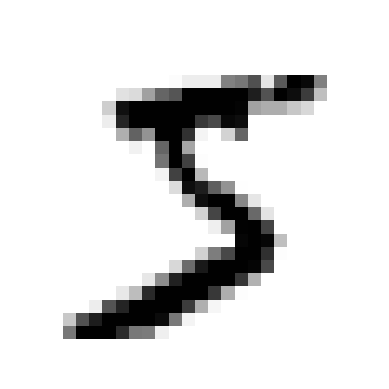

In [31]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

digit_rand = X[0]
digit_img = digit_rand.reshape(28, 28)

plt.imshow(digit_img, cmap = mpl.cm.binary, interpolation = "nearest")
plt.axis("off")
plt.show()

In [32]:
y[0]

5

In [34]:
import numpy as np
y = y.astype(np.uint8) # converts strings to numbers
y

array([5, 0, 4, ..., 4, 5, 6], dtype=uint8)

Creating a separate dataset to manipulate

In [35]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]


## Training a Binary Classifier

A binary classifier is only capable of distinguishing between two classes. In this case, we will have a '5 detector', that can detect 5 or not 5.

In [36]:
y_train_5 = (y_train == 5) 
y_test_5 = (y_test == 5)
print(len(y_train_5))
print(len(X_train))

60000
60000


In [37]:
#y_train_5 = y_train_5.astype(np.uint8)
print(np.unique(y_train_5))

[False  True]


Stochastic Gradient Descent (SGD) classifier has an advantage of handling very large datasets efficiently. It deals with trining s=isntnces independently which  makes it well suited for online learning.

In [38]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [33]:
sgd_clf.predict([digit_rand])

array([ True])

## Perfomance Measures

### Measuring Accuracy Using Cross-Validation

In [40]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

StratifiedKFold provides train/test indices to split data in train/test set.  It performs startified sampling to produce folds that contin the ratio of each class.
at each iteration, the code creates a clone for the classifier, trains the clone on the training folds and makes predictions on the test fold. It counts the number of corret predictions and outputs the ratio of the orrect predictions

In [46]:
skfolds = StratifiedKFold(n_splits = 3, random_state = 42, shuffle = True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [51]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

The model achieved above 95 percent ccuracy with the validation set.


In [52]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    

In [53]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Both give high accuracy overe 90 percent. This is because a small percentage of the dataset is 5. Threefore, if the models always guess that an inage is not a 5, it will be right about 90 percent of the time.
**Accuracy is therefore not a prefered perfomance measure for classifiers**, especially with skewed data(soem classes have more examples than others.)

### Confusion Matrix

In [55]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [57]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)


array([[53892,   687],
       [ 1891,  3530]])

Confusion matrix
|---|pred negative|pred positive|
|actual negative|53892|687|
|actual positive|1891|3530|

- Precision - Accuracy of the positive predictions of the classifier.
>Precision = TP/(TP+FP)
TP - true positives
FP - false positives
- Recall( sensitivity/ true positive rate) - ratio of posiive instances correctly detected by the classifer
>Recall = TP/(TP+FN)
    FN - False Negatives
    

#### Precision and Recall

In [61]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


This proves that the model does not actually have such high accuracy.

A combination of recall and precision into one metric forms the F1 score. it is the harmonic men of precision and recall.
F1 = TP/(TP + (FN+FP)/2)

In [66]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

F1 score favors classifiers that have similar precision and recall. increasing precision reduced recall and vice versa. This is caled precion/recall tradeoff.

#### Precision/Recall Tradeoff